32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7874 - loss: 0.6885 - val_accuracy: 0.9454 - val_loss: 0.1748
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9370 - loss: 0.1996 - val_accuracy: 0.9584 - val_loss: 0.1307
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9500 - loss: 0.1590 - val_accuracy: 0.9610 - val_loss: 0.1183
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9561 - loss: 0.1374 - val_accuracy: 0.9672 - val_loss: 0.1026
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9606 - loss: 0.1250 - val_accuracy: 0.9683 - val_loss: 0.0954


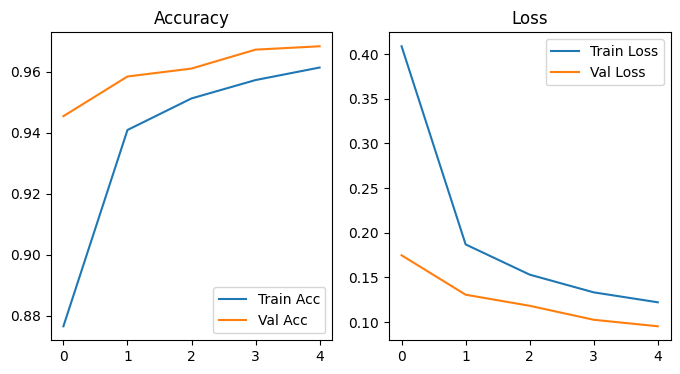

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


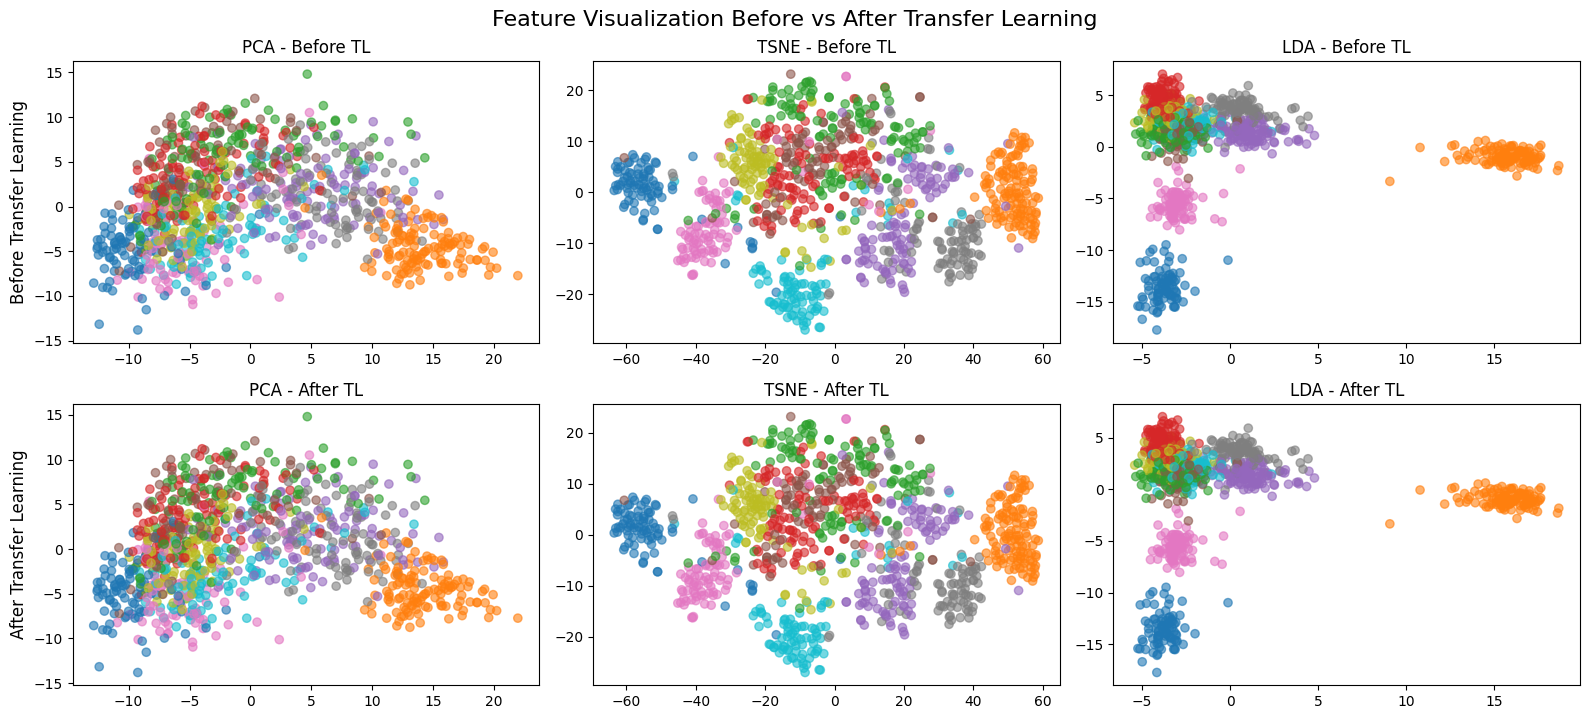

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9660 - loss: 0.1056

Test Accuracy: 0.9683 | Test Loss: 0.0954


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

def load_and_preprocess_mnist(n_samples=1000):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
    x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

    x_train = tf.image.resize(x_train, [32, 32]) / 255.0
    x_test = tf.image.resize(x_test, [32, 32]) / 255.0

    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)

    x_subset = x_test[:n_samples]
    y_subset = y_test[:n_samples]

    return (x_train, y_train_cat), (x_test, y_test_cat), (x_subset, y_subset)


def create_vgg16_models(input_shape=(32, 32, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Before Transfer Learning Model
    model_before = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

    # Transfer Learning Model
    x = base_model.output
    x = GlobalAveragePooling2D(name='gap')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(10, activation='softmax')(x)
    model_after = Model(inputs=base_model.input, outputs=output)

    return model_before, model_after

def extract_features(model, x_data, batch_size=32):
    features = model.predict(x_data, batch_size=batch_size, verbose=1)
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)
    return features


def train_model(model, x_train, y_train, x_val, y_val, epochs=5):
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=epochs, batch_size=32, verbose=1)
    return history

def reduce_dimensionality(features, labels, method='PCA'):
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif method == 'LDA':
        reducer = LDA(n_components=2)
        return reducer.fit_transform(features, labels)
    return reducer.fit_transform(features)

def plot_all_reductions(f_before, f_after, y, methods=['PCA', 'TSNE', 'LDA']):
    fig, axes = plt.subplots(2, 3, figsize=(16, 7))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for i, method in enumerate(methods):
        reduced_before = reduce_dimensionality(f_before, y, method)
        reduced_after = reduce_dimensionality(f_after, y, method)

        axes[0, i].scatter(reduced_before[:, 0], reduced_before[:, 1],
                           c=[colors[i] for i in y], alpha=0.6)
        axes[0, i].set_title(f'{method} - Before TL')

        axes[1, i].scatter(reduced_after[:, 0], reduced_after[:, 1],
                           c=[colors[i] for i in y], alpha=0.6)
        axes[1, i].set_title(f'{method} - After TL')

    axes[0, 0].set_ylabel("Before Transfer Learning", fontsize=12)
    axes[1, 0].set_ylabel("After Transfer Learning", fontsize=12)

    plt.tight_layout()
    plt.suptitle("Feature Visualization Before vs After Transfer Learning", fontsize=16, y=1.02)
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()


def main():
    (x_train, y_train), (x_test, y_test), (x_subset, y_subset) = load_and_preprocess_mnist()

    model_before, model_after = create_vgg16_models()


    features_before = extract_features(model_before, x_subset)

    history = train_model(model_after, x_train, y_train, x_test, y_test, epochs=5)
    plot_training_history(history)

    feature_extractor_post = Model(inputs=model_after.input,
                                   outputs=model_after.get_layer('gap').output)
    features_after = extract_features(feature_extractor_post, x_subset)


    plot_all_reductions(features_before, features_after, y_subset)

    loss, acc = model_after.evaluate(x_test, y_test, verbose=1)
    print(f"\nTest Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")

if __name__ == "__main__":
    main()

